# Train on 5,000 events. Test on the RAMP set.

In [1]:
!nvidia-smi

Fri Aug 25 16:50:27 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   27C    P8     9W / 180W |    633MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   29C    P8     9W / 180W |      2MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import pickle as pk
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0D:00.0)


### Load in the data.

In [3]:
%%time
modelpath   = "data/models/UNIF-10N-25T-200E-235R.h5"
trainpath   = "data/sets/UNIF-10N-25T-200E-235R.gz"
testpath    = "data/sets/RAMP-10N-25T-235R.gz"
train_frame = pd.read_csv(trainpath)
test_frame  = pd.read_csv(testpath)
train = utils.list_of_groups(train_frame, group="event_id")
test  = utils.list_of_groups(test_frame,  group="event_id")
train = [event for event in train if len(pd.unique(event["cluster_id"])) ]
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))
if (not utils.is_prepared(train_frame)) or (not utils.is_prepared(test_frame)):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py")   

Train is list of 4800 events.
Test is list of 3600 events.
CPU times: user 3.61 s, sys: 68 ms, total: 3.68 s
Wall time: 3.68 s


In [4]:
order = ["phi", "r", "z"]

### Show an example of the data.

Train 1375
Number of Hits: 105
Number of Tracks: 11


<IPython.core.display.Javascript object>


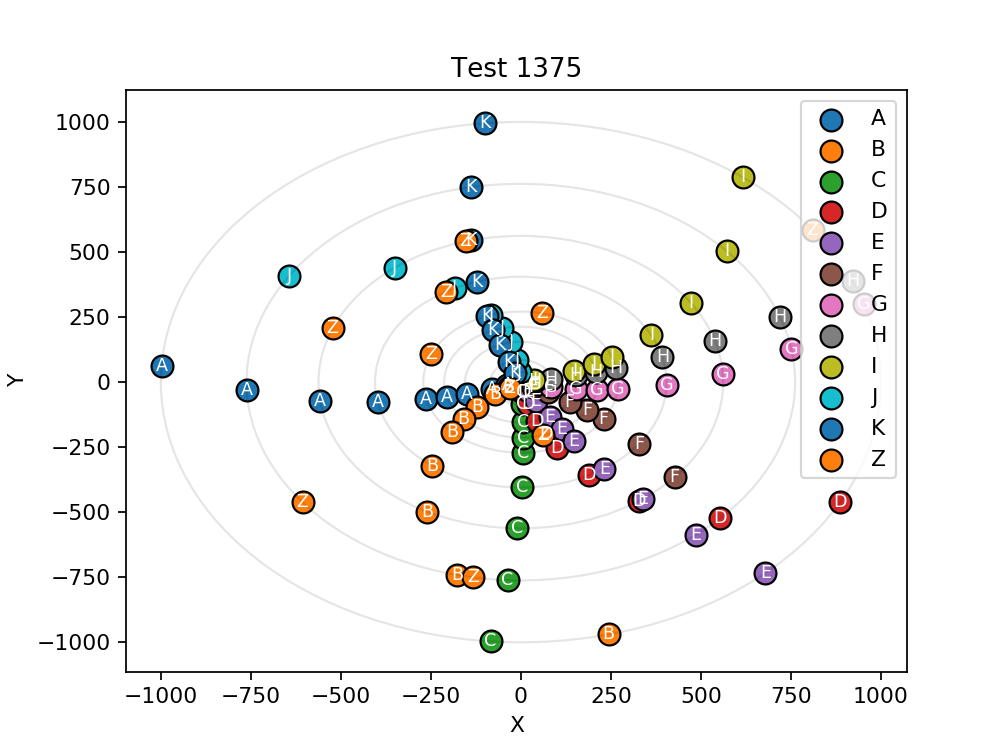

In [5]:
n = np.random.randint(len(test))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(test[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(test[n])))
visuals.Plot2D(test[n], order).plot(mode="xy", title="Test {}".format(n))

In [6]:
visuals.display(train[n], order)

,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,-3.079459,405.0,-72.933755,,,,,,,1,,,,,,,,,,,,,,,,,,,,
1,-2.922858,85.0,-12.718549,,,,,,,,,,,,,,,,,,,,,,,,,,1,
2,-2.908075,155.0,92.888403,,,,,,,,,,,,,,,,,,,,,,,,,,1,
3,-2.868357,562.0,-101.206840,,,,,,,1,,,,,,,,,,,,,,,,,,,,
4,-2.635338,39.0,0.999540,1,,,,,,,,,,,,,,,,,,,,,,,,,,
5,-2.625954,85.0,2.178484,1,,,,,,,,,,,,,,,,,,,,,,,,,,
6,-2.605468,155.0,3.972530,1,,,,,,,,,,,,,,,,,,,,,,,,,,
7,-2.585950,213.0,5.459025,1,,,,,,,,,,,,,,,,,,,,,,,,,,
8,-2.567406,271.0,6.945520,1,,,,,,,,,,,,,,,,,,,,,,,,,,
9,-2.537619,762.0,-137.223509,,,,,,,1,,,,,,,,,,,,,,,,,,,,


### Create the model.

In [7]:
input_shape  = (235, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

model = Sequential()
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 235, 256)          399360    
_________________________________________________________________
dropout_1 (Dropout)          (None, 235, 256)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 235, 256)          787968    
_________________________________________________________________
dropout_2 (Dropout)          (None, 235, 256)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 235, 256)          787968    
_________________________________________________________________
dropout_3 (Dropout)          (None, 235, 256)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 235, 27)           6939      
Total para

### Fit the model.

In [13]:
%%time
epochs     = 64
batch_size = 100
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,)]))

Epoch 1/64
48/48 [==============================] - 88s - loss: 0.5390 - acc: 0.8098 - val_loss: 0.2828 - val_acc: 0.9075
Epoch 2/64
48/48 [==============================] - 84s - loss: 0.5252 - acc: 0.8149 - val_loss: 0.2817 - val_acc: 0.9072
Epoch 3/64
48/48 [==============================] - 85s - loss: 0.5309 - acc: 0.8119 - val_loss: 0.2810 - val_acc: 0.9080
Epoch 4/64
48/48 [==============================] - 85s - loss: 0.5251 - acc: 0.8147 - val_loss: 0.2803 - val_acc: 0.9084
Epoch 5/64
48/48 [==============================] - 85s - loss: 0.5264 - acc: 0.8149 - val_loss: 0.2957 - val_acc: 0.9024
Epoch 6/64
48/48 [==============================] - 84s - loss: 0.5237 - acc: 0.8163 - val_loss: 0.2737 - val_acc: 0.9111
Epoch 7/64
48/48 [==============================] - 86s - loss: 0.5163 - acc: 0.8181 - val_loss: 0.2890 - val_acc: 0.9055
Epoch 8/64
48/48 [==============================] - 85s - loss: 0.5223 - acc: 0.8164 - val_loss: 0.2972 - val_acc: 0.9021
Epoch 9/64
48/48 [======

### Display information about the model after fitting it.

In [14]:
%%time
guesses          = model.predict(ext.extract_input(test, order))
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

Percent of hits assigned correctly: 80.74596864786817%
Percent of tracks assigned correctly: 0.0%
Percent of events with the correct number of tracks: 78.86111111111111%
CPU times: user 1min 32s, sys: 60 ms, total: 1min 32s
Wall time: 1min 32s


### Display how one of the model's predictions looks.

<IPython.core.display.Javascript object>


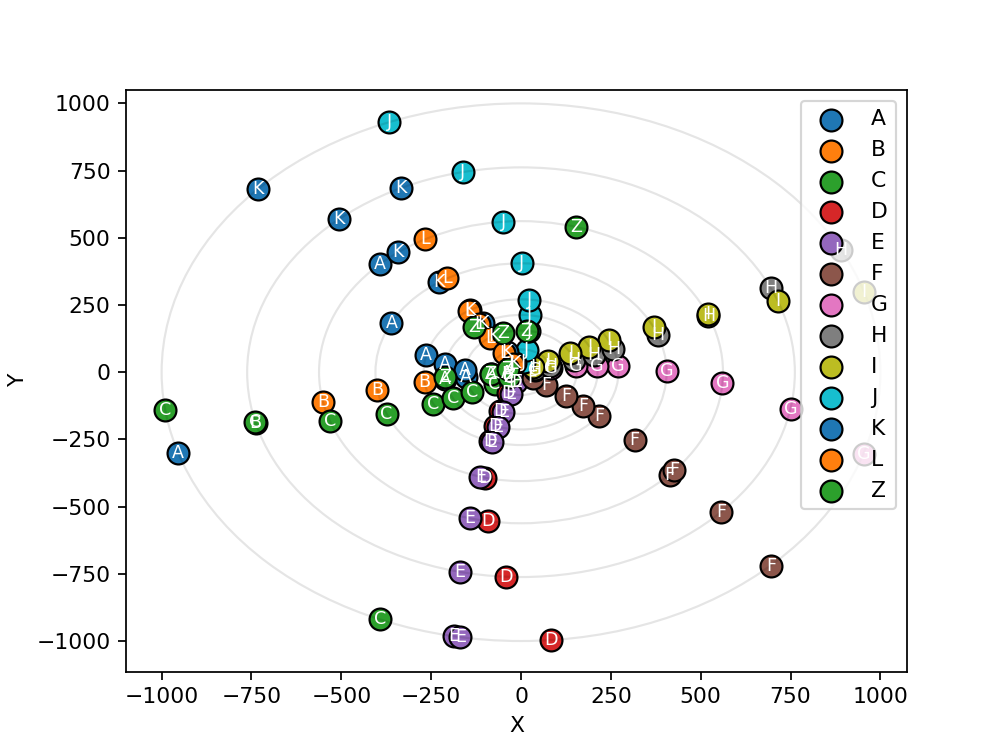

<IPython.core.display.Javascript object>


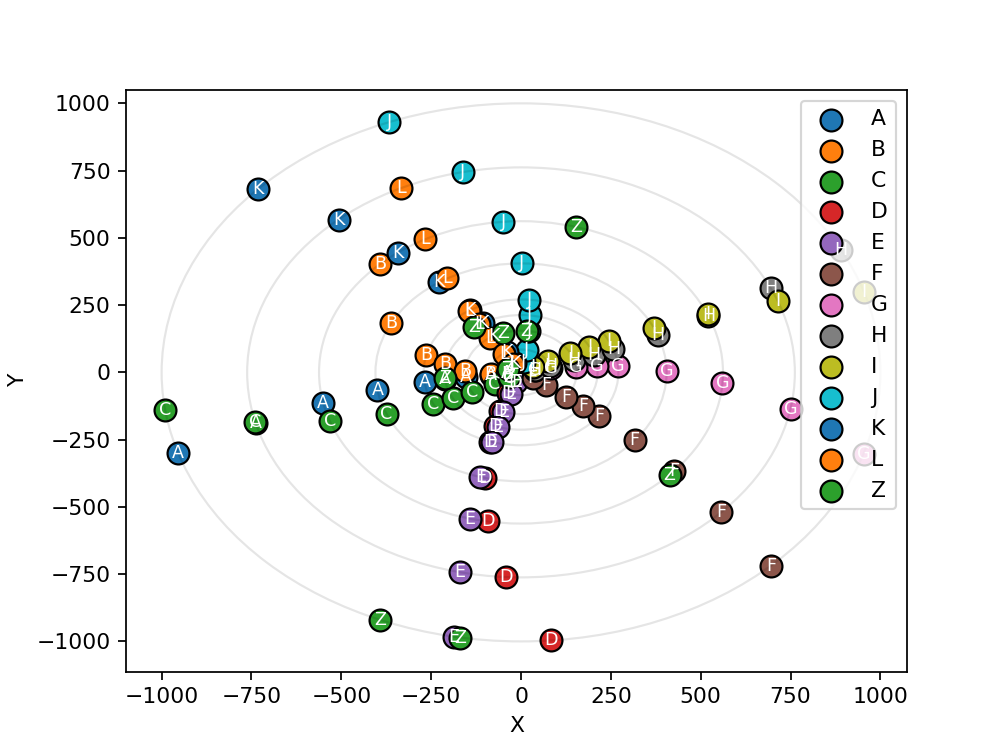

In [15]:
n = 10
d = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="xy")
d = visuals.Plot2D(test[n], order).plot(mode="xy")

In [16]:
visuals.display(test[n], order, guesses[n], mode="discrete pairs")

,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,-3.073799,85.0,9.620115,,`1`[0.0],,,,,,,,,,,,,,,,,,,,,,,,`0`[1.0],,,1,,,,,,,,,,,,,,,,,,,,,,,,,
1,-3.049729,213.0,97.675637,,,,,,,,,,,,,,,,,,,,,,,,,,`1`[1.0],,,,,,,,,,,,,,,,,,,,,,,,,,,1,
2,-3.042236,39.0,-2.634788,`1`[1.0],,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,
3,-3.041446,85.0,-5.742487,`1`[1.0],,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,
4,-3.030948,155.0,-10.471594,`1`[1.0],,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,
5,-3.019117,213.0,-14.389998,`1`[1.0],,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,
6,-3.012750,39.0,4.413935,,`1`[1.0],,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,
7,-3.006722,271.0,-18.308401,`1`[0.0],`0`[1.0],,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,
8,-3.000443,1000.0,140.924702,,,`1`[1.0],,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,
9,-2.977025,405.0,-27.361263,`1`[0.0],`0`[1.0],,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,
